In [1]:
import os
import cv2
import numpy as np
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
base_path = "/Users/vamsikrishnajayaram/Downloads"
original_images_path = os.path.join(base_path, "shot_images")
flipped_images_path = os.path.join(base_path, "flipped_shot_images")

shot_types = ["cover", "sweep", "pull", "straight", "flick", "square_cut"]

target_size = (224, 224)

dataset = []
labels = []

datagen = ImageDataGenerator(
    rotation_range = 30,
    shear_range = 0.25,
    zoom_range = 0.25,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

for index, shot_type in enumerate(shot_types):
    
    original_images_dir = os.path.join(original_images_path, shot_type)
    flipped_images_dir = os.path.join(flipped_images_path, shot_type)

    for image_filename in os.listdir(original_images_dir):
        
        image_path = os.path.join(original_images_dir, image_filename)
        
        if os.path.isfile(image_path):
            image = Image.open(image_path).convert('RGB')
            image = image.resize(target_size)
            image_array = np.array(image)
            image_array = np.expand_dims(image_array, axis=0)
            
            for i, batch in enumerate(datagen.flow(image_array, batch_size=1)):
                dataset.append(batch[0].astype(np.uint8))
                labels.append(index)
                if i >= 1:  
                    break

    for image_filename in os.listdir(flipped_images_dir):
        
        image_path = os.path.join(flipped_images_dir, image_filename)
        
        if os.path.isfile(image_path):
            image = Image.open(image_path).convert('RGB')
            image = image.resize(target_size)
            image_array = np.array(image)
            image_array = np.expand_dims(image_array, axis=0)
            
            for i, batch in enumerate(datagen.flow(image_array, batch_size=1)):
                dataset.append(batch[0].astype(np.uint8))
                labels.append(index)
                if i >= 1:  
                    break

print(f"Total {len(dataset)} images.")


Total 4540 images.


In [4]:
shot_types = ["cover", "sweep", "pull", "flick", "square_cut"]
label_indexes = [0, 1, 2, 4, 5]
shot_to_label = dict(zip(shot_types, label_indexes))
base_path = "/Users/vamsikrishnajayaram/Downloads/balancing_data"
target_size = (224, 224)

dataset1 = []
labels1 = []

datagen = ImageDataGenerator(
    rotation_range = 30,
    shear_range = 0.25,
    zoom_range = 0.25,
    horizontal_flip = True,
    fill_mode = 'nearest'
)


for shot_type in shot_types:
    
    original_images_dir = os.path.join(base_path, shot_type)
    
    for image_filename in os.listdir(original_images_dir):
        
        image_path = os.path.join(original_images_dir, image_filename)
        
        if os.path.isfile(image_path):
            
            image = Image.open(image_path).convert('RGB')
            image = image.resize(target_size)
            image_array = np.array(image)
            
            image_array = np.expand_dims(image_array, axis=0)
            
            i = 0
            for batch in datagen.flow(image_array, batch_size=1):
                
                dataset1.append(batch[0].astype(np.uint8))
                labels1.append(shot_to_label[shot_type])
                
                i += 1
                if i >= 1:
                    break

print(f"Total {len(dataset1)} images after augmentation.")

Total 733 images after augmentation.


In [5]:
lab = labels + labels1

In [6]:
data = dataset + dataset1

In [7]:
len(data)

5273

In [8]:
data = np.array(data)

In [9]:
lab = np.array(lab)

In [10]:
np.save('/Users/vamsikrishnajayaram/Downloads/data_cric.npy', data)
np.save('/Users/vamsikrishnajayaram/Downloads/lab_cric.npy', lab)

In [11]:
data = np.load('data_cric.npy')
lab = np.load('lab_cric.npy')

In [12]:
types = {0: "cover", 1: "sweep", 2: "pull", 3: "straight", 4: "flick", 5: "square_cut"}

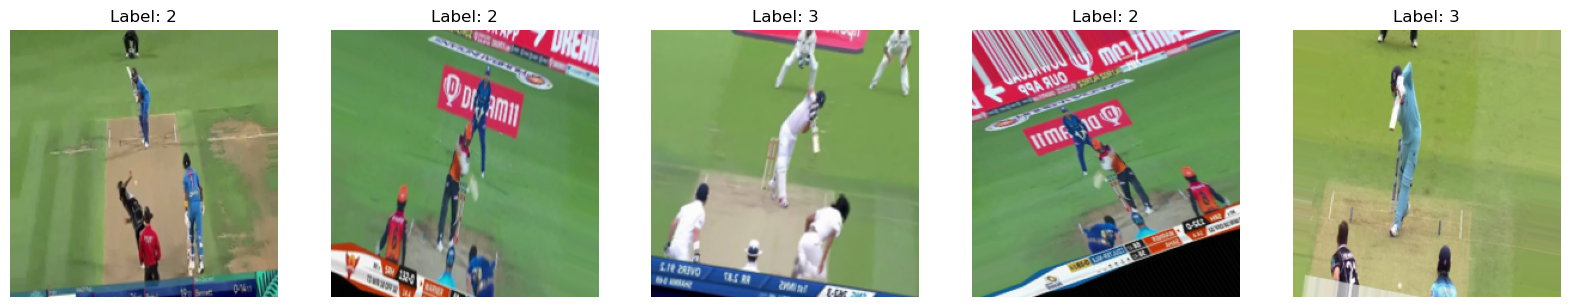

In [13]:
np.random.seed(18)


fig, axes = plt.subplots(1, 5, figsize = (20, 4))

for ax, idx in zip(axes, [2120, 2128,2271,2129,2277]):
    
    ax.imshow(data[idx])
    ax.axis('off')
    ax.set_title(f"Label: {lab[idx]}")

plt.show()

In [14]:
def object_detection():
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
    cfg.MODEL.DEVICE = 'cpu' 
    
    return cfg

def pose_est():
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
    cfg.MODEL.DEVICE = 'cpu'  
    
    return cfg

objec_det = object_detection()
pose_est = pose_est()

object_predictor = DefaultPredictor(objec_det)
pose_predictor = DefaultPredictor(pose_est)

In [15]:
def find_batsman(image):
    
    outputs = object_predictor(image)
    instances = outputs["instances"].to("cpu")

    if instances.has("pred_boxes"):
        boxes = instances.pred_boxes
    else:
        boxes = None

    if instances.has("pred_classes"):
        classes = instances.pred_classes
    else:
        classes = None


    if boxes is not None and classes is not None:
        
        person = [box for box, cls in zip(boxes, classes) if cls == 0]

        if person:
            
            center = np.array([image.shape[1] / 2, image.shape[0] / 2])
            min_distance = float('inf')
            batsman = None

            for box in person:
                
                box_center = np.array([(box[0] + box[2]) / 2, (box[1] + box[3]) / 2])
                
                distance = np.linalg.norm(box_center - center)
                
                if distance < min_distance:
                    
                    min_distance = distance
                    
                    batsman = box

            return batsman
        
    return None

In [16]:
def pose_estimation(image, person):
    
    x1, y1, x2, y2 = map(int, person)
    
    crop = image[y1:y2, x1:x2]
    
    outputs = pose_predictor(crop)

    instances = outputs["instances"].to("cpu")
    
    if instances.has("pred_keypoints"):
        
        keypoints = instances.pred_keypoints

        keypoints[:, :, 0] += x1
        keypoints[:, :, 1] += y1

        return keypoints, person
    
    else:
        
        return None, person


In [17]:
def keypoints_extraction(image):
    
    outputs = pose_predictor(image)
    instances = outputs["instances"].to("cpu")
    
    if instances.has("pred_keypoints"):
            
        keypoints = instances.pred_keypoints 
    else:
        
        keypoints = None
    
    if keypoints is not None and len(keypoints) > 0:
        
        keypoints = keypoints[0].numpy() 
        
        keypoints = keypoints[:, :2]
        
        return keypoints.flatten()
    
    else:
        
        return None


In [18]:
images = data
extracted_keypoints = []

for img in images:
    
    kp = keypoints_extraction(img)
    
    if kp is not None:
        
        extracted_keypoints.append(kp)
        
    else:
        
        extracted_keypoints.append(None)  

/Users/vamsikrishnajayaram/anaconda3/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_keypoints_on_image(image, keypoints):

    if keypoints is not None:

        keypoints = keypoints.reshape(-1, 2)
        
        plt.imshow(image)
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c='r', marker='o')
        plt.axis('off')
        plt.show()
    else:
        print("No keypoints to display.")

plot_keypoints_on_image(data[9], extracted_keypoints[9])

No keypoints to display.


In [20]:
needed_keypoints = []
needed_labels = []

for keypoints, label in zip(extracted_keypoints, lab):
    
    if keypoints is not None:
        
        needed_keypoints.append(keypoints)
        needed_labels.append(label)

In [21]:
len(needed_keypoints)
len(needed_labels)

4261

In [22]:
key_points = np.array(needed_keypoints)

In [23]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.optim import Adam, SGD
from torch.nn import Linear, ReLU, Sequential, CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [24]:
scaler = StandardScaler()
keypoints = scaler.fit_transform(key_points)

le = LabelEncoder()
y = le.fit_transform(needed_labels)

x_tr_, x_val, y_tr_, y_val = train_test_split(keypoints, y, test_size = 0.15, random_state = 18)
x_train, x_test, y_train, y_test = train_test_split(x_tr_, y_tr_, test_size = 0.15, random_state = 18)

X_train = torch.tensor(x_train, dtype=torch.float32)
X_val = torch.tensor(x_val, dtype=torch.float32)
X_test = torch.tensor(x_test, dtype=torch.float32)

Y_train = torch.tensor(y_train, dtype=torch.long)
Y_val = torch.tensor(y_val, dtype=torch.long)
Y_test = torch.tensor(y_test, dtype=torch.long)

In [25]:
import torch
import torch.nn as nn


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate = 0.25):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_size = 34  
hidden_size = 2048
output_size = 6  

model = Model(input_size, hidden_size, output_size, dropout_rate = 0.25)

In [29]:
import time
st_time = time.time()

torch.manual_seed(18)
np.random.seed(18)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9, 0.999), eps = 1e-08, weight_decay = 0.001)

epochs = 200

best_loss_tr = float('inf')
best_loss_val = float('inf')
best_weights = model.state_dict()

bs = 32

loss_val_array = []
loss_train = []
accuracy_train_array = []
accuracy_val_array = []
accuracy_test_array = []

for epoch in range(epochs):
    model.train()
    loss_sum_train = 0
    c = 0
    acc = 0
    for j in range(0, len(X_train), bs):
        c += 1
        X_traini = X_train[j:j+bs]
        Y_traini = Y_train[j:j+bs]
        y_pred = model(X_traini)
        loss = criterion(y_pred, Y_traini)
        loss_sum_train += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss < best_loss_tr:
            best_loss_tr = loss
            best_weights = model.state_dict()

        _, predicted = torch.max(y_pred.data, 1)
        accuracy = (predicted == Y_traini).sum().item() / len(Y_traini)
        acc += accuracy

    accuracy_train_array.append((acc/c))
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1} - Best training loss: {best_loss_tr.item()}")

    loss_avg = loss_sum_train / c
    loss_train.append(loss_avg.item())

    model.eval()

    with torch.no_grad():
        loss_val_sum = 0
        C = 0
        acc = 0
        for k in range(0, len(X_val), bs):
            C += 1
            X_vali = X_val[k:k+bs]
            Y_vali = Y_val[k:k+bs]
            y_pred_val = model(X_vali)
            loss_val = criterion(y_pred_val, Y_vali)
            loss_val_sum += loss_val
            if loss_val < best_loss_val:
                best_loss_val = loss_val
                best_weights_val = model.state_dict()

            _, predicted_val = torch.max(y_pred_val.data, 1)
            accuracy_val = (predicted_val == Y_vali).sum().item() / len(Y_vali)
            acc += accuracy_val

        accuracy_val_array.append((acc / C))
        loss_val_avg = loss_val_sum / C
        loss_val_array.append(loss_val_avg.item())
        
        if epoch % 10 == 0:
    
            print(f"Epoch {epoch + 1} - Best validation loss: {best_loss_val.item()}")


en_time = time.time()
tot_time = en_time - st_time
print(f"Training time: {tot_time} seconds")


Epoch 1 - Best training loss: 1.321524977684021
Epoch 1 - Best validation loss: 1.5240280628204346
Epoch 11 - Best training loss: 1.1489503383636475
Epoch 11 - Best validation loss: 1.3488433361053467
Epoch 21 - Best training loss: 1.0347402095794678
Epoch 21 - Best validation loss: 1.2176586389541626
Epoch 31 - Best training loss: 0.9312847256660461
Epoch 31 - Best validation loss: 1.2176586389541626
Epoch 41 - Best training loss: 0.8286570906639099
Epoch 41 - Best validation loss: 1.2007653713226318
Epoch 51 - Best training loss: 0.7301878929138184
Epoch 51 - Best validation loss: 1.1277074813842773
Epoch 61 - Best training loss: 0.7301878929138184
Epoch 61 - Best validation loss: 1.1277074813842773
Epoch 71 - Best training loss: 0.66910320520401
Epoch 71 - Best validation loss: 1.0434813499450684
Epoch 81 - Best training loss: 0.6232186555862427
Epoch 81 - Best validation loss: 1.0434813499450684
Epoch 91 - Best training loss: 0.6232186555862427
Epoch 91 - Best validation loss: 1.04

In [30]:
with torch.no_grad():
    
    loss_test_sum = 0
    acc_test = 0
    y_pred = []
    y_true = []
    
    for i in range(len(X_test)):
        X_test_i = X_test[i:i+1]
        Y_test_i = Y_test[i:i+1]

        y_pred_test = model(X_test_i)
        y_pred.append(torch.argmax(y_pred_test, dim=1).item())
        y_true.append(Y_test_i.item()) 

        loss_test = criterion(y_pred_test, Y_test_i)
        loss_test_sum += loss_test
        
        _, predicted_test = torch.max(y_pred_test.data, 1)
        accuracy_test = (predicted_test == Y_test_i).sum().item() / len(Y_test_i)
        acc_test += accuracy_test

    accuracy_test_result = acc_test / len(X_test)
    print(f"Accuracy: {(accuracy_test_result * 100):.2f}%")
    
    loss = loss_test_sum/(len(X_test))
y_true = np.array(y_true)
y_pred = np.array(y_pred)

Accuracy: 63.38%


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision :.2f}")
print(f"Recall: {recall :.2f}")

Precision: 0.62
Recall: 0.62


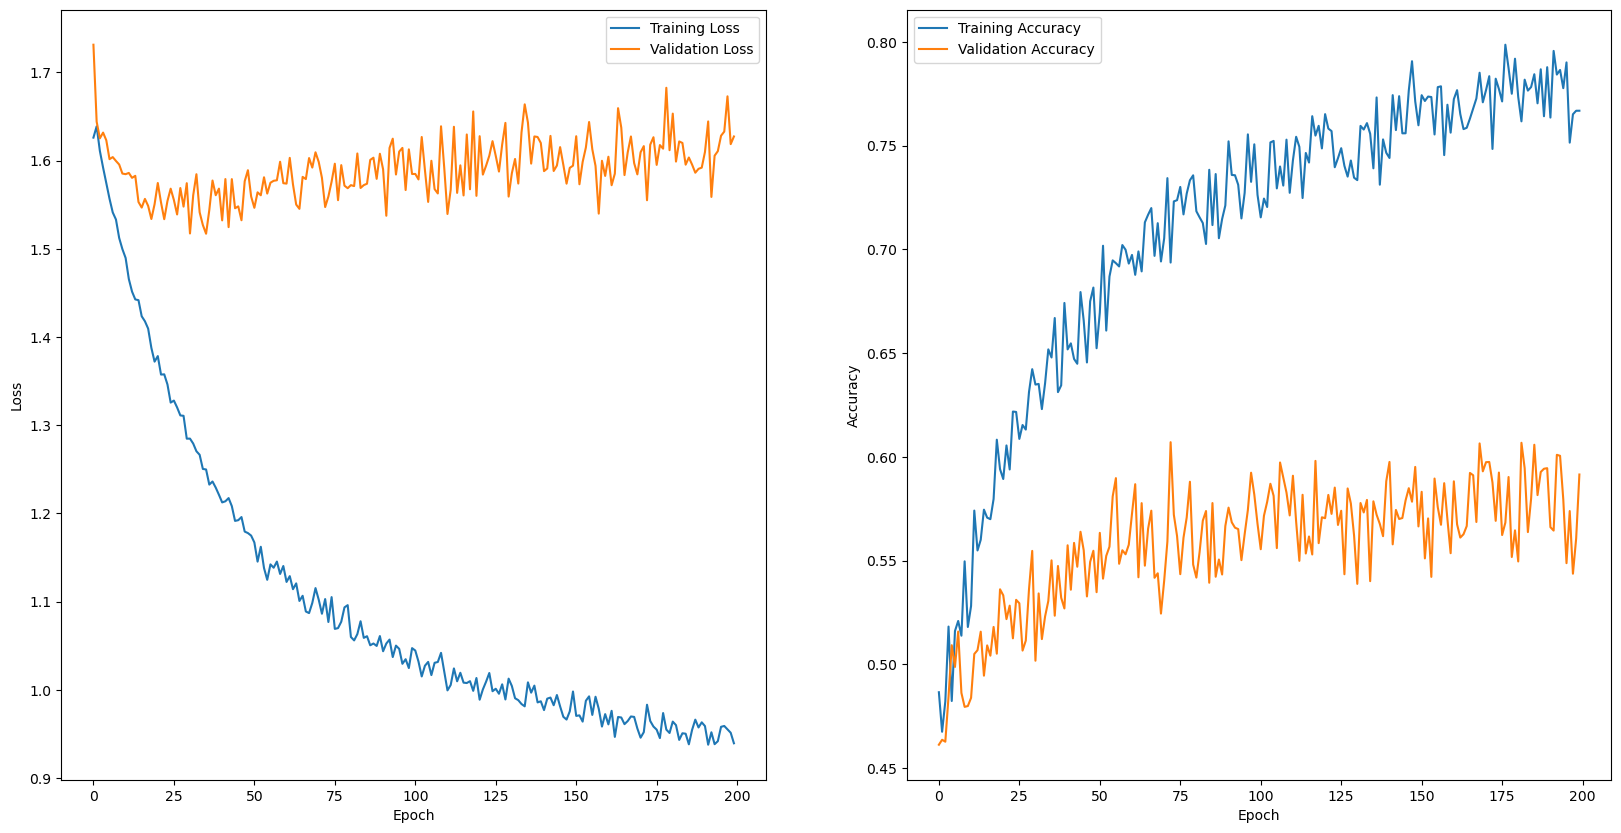

In [33]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot([i for i in range(epochs)], loss_train, label="Training Loss")
plt.plot([i for i in range(epochs)], loss_val_array, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot([i for i in range(epochs)], accuracy_train_array, label = "Training Accuracy")
plt.plot([i for i in range(epochs)], accuracy_val_array, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

In [34]:
class ModelBN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, dropout_rate = 0.3):
        
        super(ModelBN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size) 
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)  
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_size, output_size)

        self.relu = nn.ReLU()

    def forward(self, x):
        
        x = self.fc1(x)
        x = self.bn1(x)  
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)  
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x) 
        
        return x


input_size = 34  
hidden_size = 2048
output_size = 6  
dropout_rate = 0.3

model = ModelBN(input_size, hidden_size, output_size, dropout_rate)

In [35]:
import time
st_time = time.time()

torch.manual_seed(18)
np.random.seed(18)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9, 0.999), eps = 1e-08, weight_decay = 0.001)

epochs = 200

best_loss_tr = float('inf')
best_loss_val = float('inf')
best_weights = model.state_dict()

bs = 32

loss_val_array = []
loss_train = []
accuracy_train_array = []
accuracy_val_array = []
accuracy_test_array = []

for epoch in range(epochs):
    model.train()
    loss_sum_train = 0
    c = 0
    acc = 0
    for j in range(0, len(X_train), bs):
        c += 1
        X_traini = X_train[j:j+bs]
        Y_traini = Y_train[j:j+bs]
        y_pred = model(X_traini)
        loss = criterion(y_pred, Y_traini)
        loss_sum_train += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss < best_loss_tr:
            best_loss_tr = loss
            best_weights = model.state_dict()

        _, predicted = torch.max(y_pred.data, 1)
        accuracy = (predicted == Y_traini).sum().item() / len(Y_traini)
        acc += accuracy

    accuracy_train_array.append((acc/c))
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1} - Best training loss: {best_loss_tr.item()}")

    loss_avg = loss_sum_train / c
    loss_train.append(loss_avg.item())

    model.eval()

    with torch.no_grad():
        loss_val_sum = 0
        C = 0
        acc = 0
        for k in range(0, len(X_val), bs):
            C += 1
            X_vali = X_val[k:k+bs]
            Y_vali = Y_val[k:k+bs]
            y_pred_val = model(X_vali)
            loss_val = criterion(y_pred_val, Y_vali)
            loss_val_sum += loss_val
            if loss_val < best_loss_val:
                best_loss_val = loss_val
                best_weights_val = model.state_dict()

            _, predicted_val = torch.max(y_pred_val.data, 1)
            accuracy_val = (predicted_val == Y_vali).sum().item() / len(Y_vali)
            acc += accuracy_val

        accuracy_val_array.append((acc / C))
        loss_val_avg = loss_val_sum / C
        loss_val_array.append(loss_val_avg.item())
        
        if epoch % 10 == 0:
    
            print(f"Epoch {epoch + 1} - Best validation loss: {best_loss_val.item()}")


en_time = time.time()
tot_time = en_time - st_time
print(f"Training time: {tot_time} seconds")

Epoch 1 - Best training loss: 1.5191822052001953
Epoch 1 - Best validation loss: 1.571238398551941
Epoch 11 - Best training loss: 1.1639302968978882
Epoch 11 - Best validation loss: 1.4096267223358154
Epoch 21 - Best training loss: 1.0868651866912842
Epoch 21 - Best validation loss: 1.3432596921920776
Epoch 31 - Best training loss: 0.8559027910232544
Epoch 31 - Best validation loss: 1.3198561668395996
Epoch 41 - Best training loss: 0.8306851387023926
Epoch 41 - Best validation loss: 1.2398242950439453
Epoch 51 - Best training loss: 0.7860777378082275
Epoch 51 - Best validation loss: 1.2203724384307861
Epoch 61 - Best training loss: 0.6729020476341248
Epoch 61 - Best validation loss: 1.1855711936950684
Epoch 71 - Best training loss: 0.5420154929161072
Epoch 71 - Best validation loss: 1.1270076036453247
Epoch 81 - Best training loss: 0.5420154929161072
Epoch 81 - Best validation loss: 1.1270076036453247
Epoch 91 - Best training loss: 0.3749050498008728
Epoch 91 - Best validation loss: 1.

In [36]:
with torch.no_grad():
    
    loss_test_sum = 0
    acc_test = 0
    y_pred = []
    y_true = []
    
    for i in range(len(X_test)):
        X_test_i = X_test[i:i+1]
        Y_test_i = Y_test[i:i+1]

        y_pred_test = model(X_test_i)
        y_pred.append(torch.argmax(y_pred_test, dim=1).item())
        y_true.append(Y_test_i.item()) 

        loss_test = criterion(y_pred_test, Y_test_i)
        loss_test_sum += loss_test
        
        _, predicted_test = torch.max(y_pred_test.data, 1)
        accuracy_test = (predicted_test == Y_test_i).sum().item() / len(Y_test_i)
        acc_test += accuracy_test

    accuracy_test_result = acc_test / len(X_test)
    print(f"Accuracy: {(accuracy_test_result * 100):.2f}%")
    
    loss = loss_test_sum/(len(X_test))
y_true = np.array(y_true)
y_pred = np.array(y_pred)

Accuracy: 59.97%


In [38]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision: 0.59
Recall: 0.60


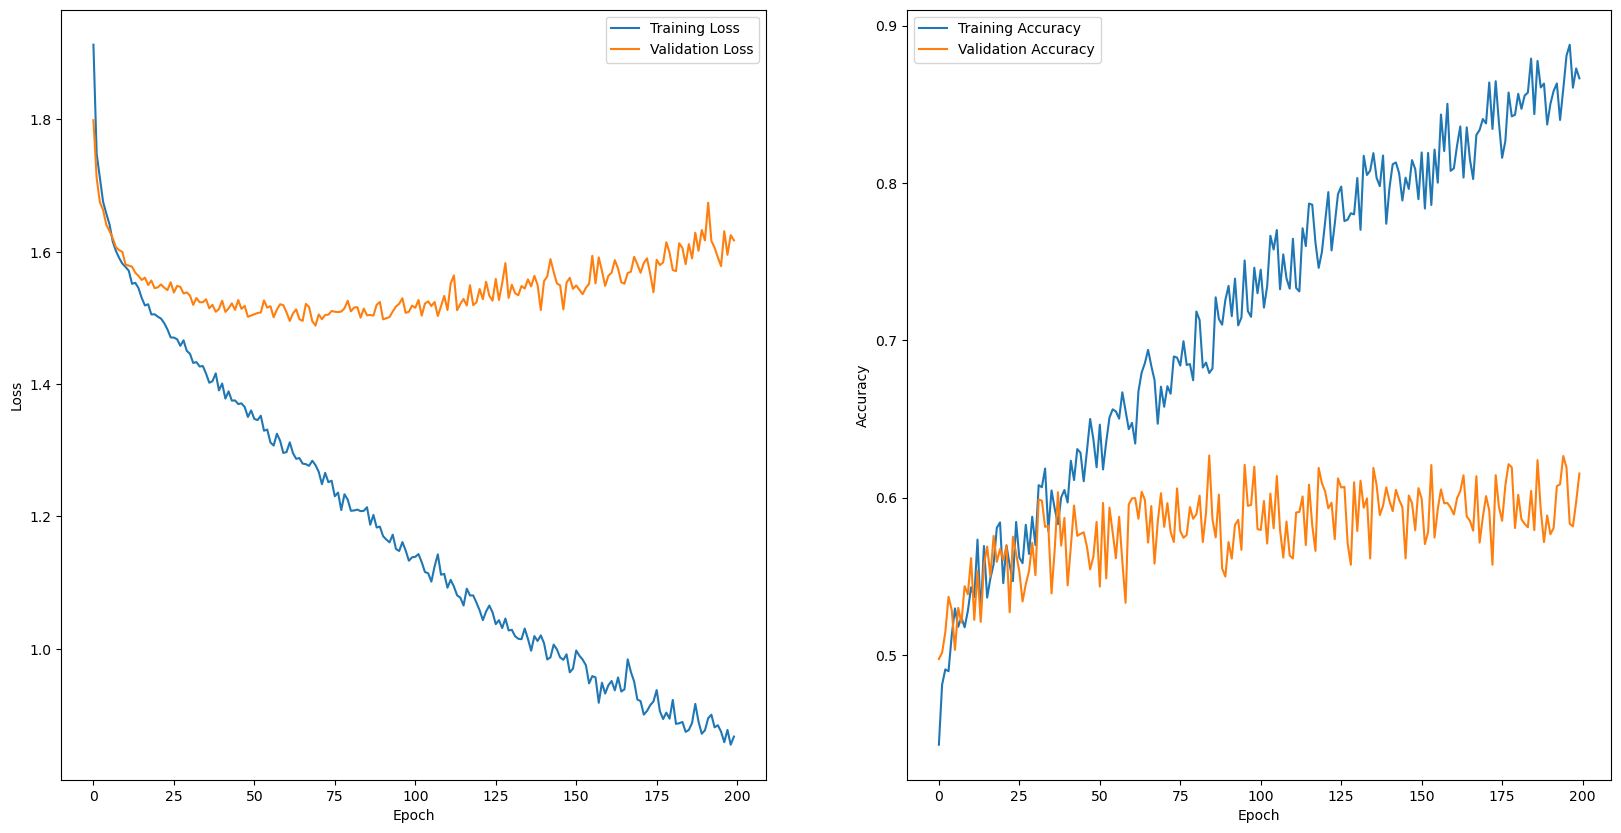

In [39]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot([i for i in range(epochs)], loss_train, label="Training Loss")
plt.plot([i for i in range(epochs)], loss_val_array, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot([i for i in range(epochs)], accuracy_train_array, label = "Training Accuracy")
plt.plot([i for i in range(epochs)], accuracy_val_array, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

In [44]:
from detectron2.utils.visualizer import Visualizer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

predictor = DefaultPredictor(cfg)

In [54]:
types = {0: "cover", 1: "sweep", 2: "pull", 3: "straight", 4: "flick", 5: "square_cut"}

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    
    if not ret:
        break
    
    outputs = predictor(frame)
    
    if len(outputs["instances"]) > 0:
        
        keypoints = outputs["instances"].pred_keypoints[0].cpu().numpy()

        keypoints = keypoints[:, :2].flatten() 

        keypoints_tensor = torch.tensor(keypoints, dtype=torch.float32).unsqueeze(0)

        with torch.no_grad():
            output = model(keypoints_tensor)
            _, predicted_class = torch.max(output, dim=1)
            predicted_class = predicted_class.item()

        predicted_shot = types.get(predicted_class, "_")

        v = Visualizer(frame[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        frame = np.array(v.get_image()[:, :, ::-1], dtype=np.uint8)

        cv2.putText(frame, f'Predicted shot: {predicted_shot}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow('Real-time Shot Prediction', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()